In [2]:
import pdb
import configparser
import gc
import glob
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.font_manager as fm
import collections
import astropy.io.fits as pf
import os
import sys
import subprocess as S
import numpy as np
#matplotlib.use('Pdf')

import lsst.daf.butler as dB
import lsst.afw.display as afwDisplay
import numpy as np
import pylab as plt
import astropy.io.fits as pf
import lsst.afw.image as afwImage
from matplotlib.backends.backend_pdf import PdfPages



In [3]:
from lsst.cp.pipe.utils import (funcPolynomial, irlsFit)

In [4]:
# Read in median (of 48 exposures) flat and dark
hdulist = pf.open("/project/plazas/PPL/H4RG/output/2021MAR26/PPL-data-2021-02-18/stacked/flats_median_stacked.fits")
medianFlatsCube = 2**16 - 1 - hdulist[0].data
headerFlatsCube = hdulist[0].header

hdulist = pf.open("/project/plazas/PPL/H4RG/output/2021MAR26/PPL-data-2021-02-18/stacked/darks_median_stacked.fits")
medianDarksCube = 2**16 - 1 - hdulist[0].data
headerDarksCube = hdulist[0].header

In [5]:
#medianFlatsCube=-medianDarksCube

In [6]:
meanFlats = [np.mean(x) for x in medianFlatsCube]
meanDarks = [np.mean(x) for x in medianDarksCube]

print (meanFlats)
print (meanDarks)


[9715.943010240793, 11426.017488092184, 13102.266193062067, 14772.532860279083, 16436.42029634118, 18094.360560655594, 19744.81346285343, 21387.526940107346, 23021.748909801245, 24647.882715135813]
[9619.048173367977, 9669.759227961302, 9720.090130090714, 9770.667324662209, 9821.104289650917, 9871.706164628267, 9922.218574136496, 9972.941509872675, 10023.564531773329, 10074.093306928873]


In [7]:
framtime = headerFlatsCube['FRAMTIME']
nframes = headerFlatsCube['NFRAMES']
expTimes = np.array([i*framtime for i in range(nframes)])/1000.
detSizeX, detSizeY = headerFlatsCube['DETSIZEX'], headerFlatsCube['DETSIZEY']
print (expTimes)
print (detSizeX, detSizeY)

[ 0.          2.72990632  5.45981264  8.18971896 10.91962528 13.6495316
 16.37943792 19.10934424 21.83925056 24.56915688]
4096 4096


In [8]:
polyFit, polyFitErr, chiSq, weights = irlsFit([0.0, 100.0, -1e-6, 1e-10], expTimes,
                                               meanFlats, funcPolynomial)

In [9]:
polyFit

array([ 9.72097928e+03,  6.23335680e+02, -8.12478211e-01,  7.04923733e-03])

In [10]:
polyFitErr

array([4.48897573e+00, 1.62176840e+00, 1.56641405e-01, 4.15713052e-03])

In [11]:
# Fractional residuals
# 100 * (k0 + k1*Time - meanSignal) / (k0 + k1*Time)
linearPart = polyFit[0] +expTimes*polyFit[1]
res = 100 * ((linearPart - meanFlats)/linearPart)
print (res)

[ 0.05180822 -0.02967967  0.16769772  0.36011555  0.55150894  0.73979461
  0.93349622  1.13250089  1.33887154  1.54949514]


In [12]:
# Correction coefficients (Eq. 37 of Jenna's paper, 3rd BFE paper from OSU group)
k1 = polyFit[1]
correctionCoeffs = [-coeff/(k1**order) for order, coeff in enumerate(polyFit)]
print (correctionCoeffs)

[-9720.979276476573, -1.0, 2.0910660390389787e-06, -2.910557419385757e-11]


In [19]:
# Correct the mean signal
correction = np.zeros_like(meanFlats)
for order, coeff in enumerate(correctionCoeffs[2:]):
    print (coeff, order+2)
    correction += coeff * np.power(meanFlats, order+2)
correctedMeanFlats = meanFlats + correction
print (meanFlats)
print (correctedMeanFlats)

2.0910660390389787e-06 2
-2.910557419385757e-11 3
[9715.943010240793, 11426.017488092184, 13102.266193062067, 14772.532860279083, 16436.42029634118, 18094.360560655594, 19744.81346285343, 21387.526940107346, 23021.748909801245, 24647.882715135813]
[ 9886.64363138 11655.59716241 13395.77225939 15135.03158981
 16872.09387084 18606.56063984 20335.98656234 22059.28939665
 23774.88277478 25482.41532977]


In [14]:
### Check the fractional NLL residuals

In [15]:
polyFit, polyFitErr, chiSq, weights = irlsFit([0.0, 100.0, -1e-6, 1e-10], expTimes,
                                               correctedMeanFlats, funcPolynomial)
print (polyFit)
linearPart = polyFit[0] +expTimes*polyFit[1]
resAfter = 100 * ((linearPart - correctedMeanFlats)/linearPart)
print (" ")
print ("Fractional NL after correction: ", resAfter)

[ 9.89181483e+03  6.43609498e+02 -3.74660797e-01  3.96526502e-04]
 
Fractional NL after correction:  [ 0.05227757 -0.05827802  0.07481718  0.18310705  0.28189181  0.37598749
  0.47857076  0.59250255  0.72190931  0.86498469]


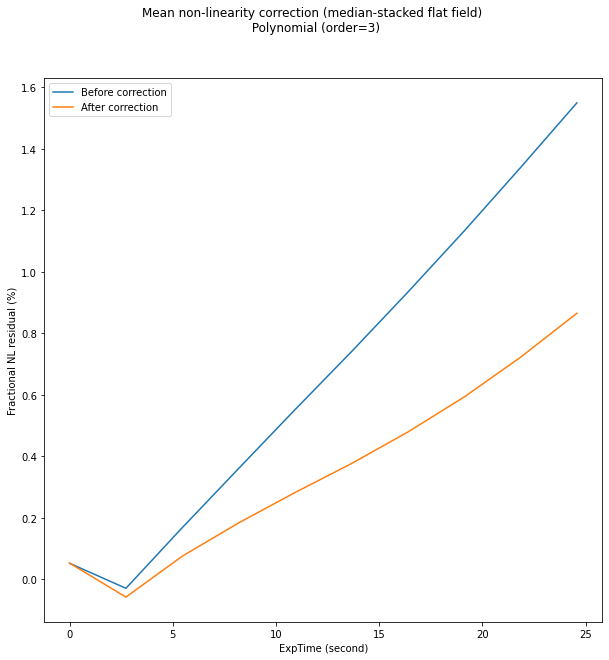

In [18]:
fig = plt.figure(figsize=(10,10))
plt.plot(expTimes, res, label="Before correction")
plt.plot(expTimes, resAfter, label="After correction")
plt.legend()
plt.suptitle("Mean non-linearity correction (median-stacked flat field) \n Polynomial (order=3)")
plt.xlabel("ExpTime (second)")
plt.ylabel("Fractional NL residual (%)")
plt.show()

In [16]:
medianFlatsCube[:, 50, 50]

array([ 9773.5, 10659. , 11514.5, 12376. , 13224.5, 14089.5, 14929.5,
       15787. , 16621.5, 17481.5])

In [17]:
## now, let's try to get correction coefficients for each individual pixel of the master flat (i.e, approx 16e6 fits!)
from multiprocessing import Pool
from multiprocessing import cpu_count

def fit_pixel_ramp(medianFlatsCube, expTimes, counter=0, detSize=(4096, 4096)):
    index_x, index_y = np.unravel_index(counter, detSize)
    polyFit, polyFitErr, chiSq, weights = irlsFit([0.0, 100.0, -1e-6, 1e-10], expTimes,
                                                  medianFlatsCube[:, index_x, index_y],
                                                  funcPolynomial)
    # Correction coefficients (Eq. 37 of Jenna's paper, 3rd BFE paper from OSU group)
    k1 = polyFit[1]
    correctionCoeffs = [-coeff/(k1**order) for order, coeff in enumerate(polyFit)]
    return correctionCoeffs[2:] #(polyFit, polyFitErr, chiSq, weights)

def nl_function (index):
    """Function to be passed to nultiprocess.
    Must have singel index as input.
    """
    index_x, index_y = np.unravel_index(index, (detSizeX, detSizeY))
    corrCoeffs = fit_pixel_ramp (medianFlatsCube, expTimes, counter=index, detSize=(detSizeX, detSizeY))
    return index_x, index_y, corrCoeffs[0], corrCoeffs[1] #polyFit, polyFitErr, chiSq, weights)

In [24]:
processes = cpu_count()
use = 25
print("I have ", processes, "cores here. Using: %g" % use)
pool = Pool(processes=use)
npix_total = 20*10 #detSizeX*detSizeY
results = pool.map(nl_function, list(range(npix_total)))
pool.close()
pool.join()

I have  32 cores here. Using: 25


In [25]:
results = np.array(results)

In [26]:
type(results)
results.shape

(200, 4)

In [34]:
a = np.zeros((20,10))
b = results[:,2].reshape((20,10))
b[0,4]

-0.000253243828969985

In [22]:
for line in results: 
    print (line)
    

[ 0.0000000e+00  0.0000000e+00 -2.4335814e-04 -1.7688860e-08]
[ 0.00000000e+00  1.00000000e+00 -2.49866385e-04 -1.86412206e-08]
[ 0.00000000e+00  2.00000000e+00 -2.45738282e-04 -1.80520067e-08]
[ 0.00000000e+00  3.00000000e+00 -2.47013923e-04 -1.82208482e-08]
[ 0.00000000e+00  4.00000000e+00 -2.53243829e-04 -1.91539424e-08]
[ 0.00000000e+00  5.00000000e+00 -2.53757527e-04 -1.92389799e-08]
[ 0.00000000e+00  6.00000000e+00 -2.55664590e-04 -1.95296225e-08]
[ 0.00000000e+00  7.00000000e+00 -2.58529559e-04 -1.99727267e-08]
[ 0.00000000e+00  8.00000000e+00 -2.56808576e-04 -1.96902145e-08]
[ 0.00000000e+00  9.00000000e+00 -2.57518800e-04 -1.97980675e-08]
[ 0.00000000e+00  1.00000000e+01 -2.62766077e-04 -2.06190798e-08]
[ 0.00000000e+00  1.10000000e+01 -2.61298781e-04 -2.03843405e-08]
[ 0.00000000e+00  1.20000000e+01 -2.62768681e-04 -2.06186536e-08]
[ 0.00000000e+00  1.30000000e+01 -2.66112948e-04 -2.11589667e-08]
[ 0.00000000e+00  1.40000000e+01 -2.60111282e-04 -2.02108724e-08]
[ 0.00000000e+